In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score # função para validação cruzada
from sklearn.linear_model import LinearRegression

## Carregando Dados de treino e teste

In [26]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Modelo Random Forest


In [27]:
B_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)

Modelo só trabalha com variáveis numéricas
A variável datetime é string, logo vamos trabalhar com ela por enquanto...
Primeiro vamos separar data de hora...

In [28]:
def splitDate(value):
    return value.split(" ")[0]
def splitTime(value):
    return value.split(" ")[1]


train["date"] = train["datetime"].map(splitDate)
train["time"] = train["datetime"].map(splitTime)

test["date"] = test["datetime"].map(splitDate)
test["time"] = test["datetime"].map(splitTime)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00


Agora que separamos, podemos alterar os valores de string data e string time para valores numéricos que sejam interessantes pro nosso modelo. Um estudo de interesse é saber se estamos lidando com finais de semana ou dias úteis. Além disso, outr informação interessante é saber se estamos lidando com aluguéis de bike no período da manhã, tarde, ou noite. Para fazermos essas análises, iremos usar a biblioteca datetime

In [29]:
from datetime import datetime

def isWeekend(value):
    value = datetime.strptime(value, "%Y-%m-%d").strftime('%A')

    if value == "Saturday" or value == "Sunday":
        return 1
    else:
        return 0

train["weekend"] = train["date"].map(isWeekend)
test["weekend"] = test["date"].map(isWeekend)

train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00,1


Com a coluna weekend pronta, podemos agora trabalhar com a coluna time, a fim de dividir os períodos de tempo em madrugada/manhã/tarde/noite;

In [30]:
def getDayPeriod(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))
    if value <= 5:
        return 0
    elif value >= 6 and value <= 11:
        return 1
    elif value >= 12 and value <= 17:
        return 2
    elif value >= 18 and value <= 23:
        return 3

train["period"] = train["time"].map(getDayPeriod)
test["period"] = test["time"].map(getDayPeriod)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,weekend,period
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00,1,0


In [31]:
def getHour(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))
    return value
    
train["Hour"] = train["time"].map(getHour)
test["Hour"] = test["time"].map(getHour)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,weekend,period,Hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,1,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,1,0,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00,1,0,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00,1,0,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00,1,0,4


In [32]:
def getMonth(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%m'))
    return value

train["Month"] = train["date"].map(getMonth)
test["Month"] = test["date"].map(getMonth)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,weekend,period,Hour,Month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,1,0,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,1,0,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00,1,0,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00,1,0,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00,1,0,4,1


In [34]:
j = []
models = [train, test]
for type in models:
    j.clear()
    for i in type["temp"].iteritems() :
        if i[1] < 10:
            x = 0
            j.append(x)

        elif i[1] > 10 and i[1] < 20:
            x = 1
            j.append(x)
        elif i[1] > 20 and i[1] < 30:
            x = 2
            j.append(x)
        else:
            x = 3
            j.append(x)

    type["faixa_temp"] = j

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,weekend,period,Hour,Month,faixa_temp
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,1,0,0,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,1,0,1,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00,1,0,2,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00,1,0,3,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00,1,0,4,1,0


In [ ]:
# P = sns.pairplot(train) # gera graficos relacionando todas as variaveis duas a duas

In [ ]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekend,period,Hour,Month,faixa_temp
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,0.290557,1.507441,11.541613,6.521495,1.511023
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.454040,1.116169,6.915838,3.444373,0.842497
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,0.000000,1.000000,6.000000,4.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,0.000000,2.000000,12.000000,7.000000,2.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.000000,3.000000,18.000000,10.000000,2.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.000000,3.000000,23.000000,12.000000,3.000000


In [ ]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekend,period,Hour,Month,faixa_temp
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.002433,-0.007340,-0.006546,0.971524,0.264822
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,-0.109748,-0.000402,-0.000354,0.001731,0.000701
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.934780,0.002975,0.002780,-0.003394,0.032350
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.032078,-0.022127,-0.022740,0.012144,-0.051734
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,-0.030873,0.148428,0.145430,0.257589,0.940149
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,-0.023405,0.143400,0.140343,0.264173,0.921864
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,0.010463,-0.285974,-0.278011,0.204537,-0.084166
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.016816,0.149285,0.146631,-0.150192,-0.007558
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.311558,0.308472,0.302045,0.092722,0.448328
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,-0.114959,0.412465,0.380540,0.169451,0.315253


# Melhores Correlações:
 temp,atemp,faixa_temp
 season
 period, Hour, Month 

In [35]:
treino_2 = train[["count","period","faixa_temp","Hour","Month"]]
treino_2.head()

,count,period,faixa_temp,Hour,Month
0,16,0,0,0,1
1,40,0,0,1,1
2,32,0,0,2,1
3,13,0,0,3,1
4,1,0,0,4,1


In [36]:
treino_2.corr()

,count,period,faixa_temp,Hour,Month
count,1.000000,0.428993,0.386511,0.400601,0.166862
period,0.428993,1.000000,0.151829,0.968951,-0.007641
faixa_temp,0.386511,0.151829,1.000000,0.149553,0.264189
Hour,0.400601,0.968951,0.149553,1.000000,-0.006818
Month,0.166862,-0.007641,0.264189,-0.006818,1.000000


<AxesSubplot:xlabel='Hour', ylabel='count'>

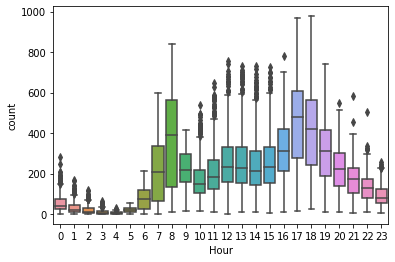

In [ ]:
sns.boxplot(x = "Hour",y="count",data=train)
# maior contagem no periodo da manha entre 7 e 8 Hrs
# e no periodo da tarde entre 17 e 18Hrs

<AxesSubplot:xlabel='season', ylabel='count'>

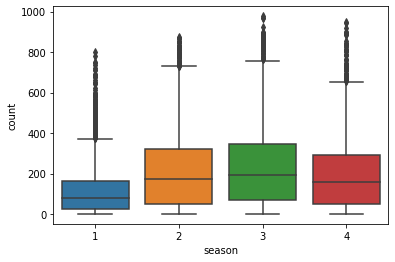

In [ ]:
sns.boxplot(x = "season",y="count",data=train)
#contagem maior no verao e no outono

<AxesSubplot:xlabel='season', ylabel='faixa_temp'>

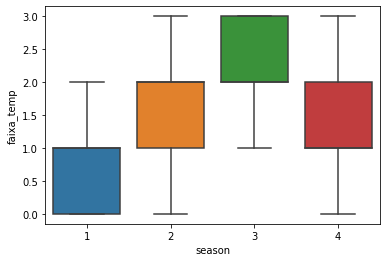

In [ ]:
sns.boxplot(x = "season",y="faixa_temp",data=train)

<AxesSubplot:xlabel='faixa_temp', ylabel='count'>

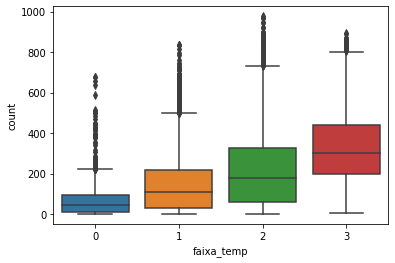

In [ ]:
sns.boxplot(x = "faixa_temp",y="count",data=train)
# maior contagem conforme maior a temperatura

<AxesSubplot:xlabel='Month', ylabel='count'>

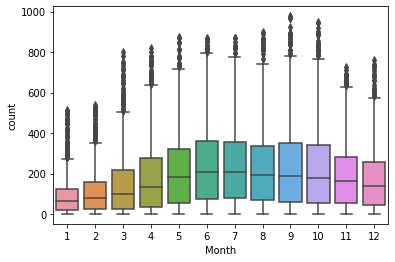

In [ ]:
sns.boxplot(x = "Month",y="count",data=train)

In [39]:
#["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","count","weekend","period"]
features = ["faixa_temp","weekend","period", "Hour", "Month"]

x_treino = train[features]
y_treino = train["count"]

x_teste = test[features]


In [41]:
P = B_model.fit(x_treino, y_treino)
prev = B_model.predict(x_teste)
prev

array([ 17,  12,   2, ..., 168, 106,  75], dtype=int64)

In [47]:
sub = pd.Series(prev, index=test["datetime"], name="count")
sub.to_csv("result_model.csv", header=True)
# test.head()
# P = B_model.fit(x_treino,y_treino)
# previsao = B_model.predict(x_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(P,x_treino,y_treino,cv=2))

In [ ]:
# LModel = LinearRegression()
# L = LModel.fit(X=x_treino,y=y_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(L,x_treino,y_treino,cv=2))

In [ ]:
# # Outro modelo para testar
# B_model = SVC(gamma="auto")
# P = B_model.fit(x_treino,y_treino)
# previsao = B_model.predict(x_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(P,x_treino,y_treino,cv=2))